# A Text Mining Approach to Analyze The Cyber Security Related Articles

## PART-3: Text Mining

__Feature Engineering with NLP techniques__


__Importing of Required Libraries__

In [148]:
import nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from autocorrect import Speller
import pickle
import re


import spacy
import en_core_web_sm
from spacy import displacy

import numpy as np
import pandas as pd


import warnings
warnings.filterwarnings("ignore")

__Loading Data__

As mentioned Part-2 that pandas parquet options doesn't support timedelta type. So we need to use __fastparquet__ option, to keep the timedelta type format.

In [2]:
df_sum=pd.read_parquet('df_sum_parquet.gzip',engine='fastparquet')
df_investigator_cyber=pd.read_parquet('df_investigator_cyber_parque.gzip',engine='fastparquet')
df_sum.head(2)

,AwardID,AwardTitle,AwardEffectiveDate,AwardExpirationDate,AwardAmount,ProgramOfficer,Institution_Name,Institution_StateName,Abstract,Year,Award_Duration,AwardAmount_Million,Abstract_Lenght
0,0110599,Collaborative Research Testing Affect Control ...,2001-08-15,2004-07-31,300000.0,Patricia White,University of Arizona,Arizona,The investigators will conduct a series of exp...,2001,1081 days,0.30,2194
1,0112426,Federal Cyber Service Initiative,2001-06-01,2007-06-30,149995.0,Timothy V. Fossum,University of Tulsa,Oklahoma,This program produces a cadre of computer scie...,2001,2220 days,0.15,765


### A-) Word Frequency

__Replacing Of Contraction Words__

In [3]:
#Replace contraction words to alternative forms before tokenization
replacement_patterns = {
    r"won\'t": "will not",
    r"can\'t": "cannot",
    r"i\'m": "i am",
    r"ain\'t": "is not",
    r"(\w+)\'ll": "\g<1> will",
    r"(\w+)n\'t": "\g<1> not",
    r"(\w+)\'ve": "\g<1> have",
    r"(\w+)\'s": "\g<1> is",
    r"(\w+)\'re": "\g<1> are",
    r"(\w+)\'d": "\g<1> would",
    r"&": "and",
    r"<br/>":" "}

df_sum['Abstract']=df_sum['Abstract'].replace(replacement_patterns, regex=True)
df_sum.head(2)

,AwardID,AwardTitle,AwardEffectiveDate,AwardExpirationDate,AwardAmount,ProgramOfficer,Institution_Name,Institution_StateName,Abstract,Year,Award_Duration,AwardAmount_Million,Abstract_Lenght
0,0110599,Collaborative Research Testing Affect Control ...,2001-08-15,2004-07-31,300000.0,Patricia White,University of Arizona,Arizona,The investigators will conduct a series of exp...,2001,1081 days,0.30,2194
1,0112426,Federal Cyber Service Initiative,2001-06-01,2007-06-30,149995.0,Timothy V. Fossum,University of Tulsa,Oklahoma,This program produces a cadre of computer scie...,2001,2220 days,0.15,765


__Merge All Values in Abstract Columns to A Single String__

In [4]:
abstract_list=df_sum['Abstract'].tolist()
abstract_sum=' '.join(abstract_list)
print('Total character number of all Abstract columns is: {}'.format(len(abstract_sum)))

Total character number of all Abstract columns is: 17055166


__Tokenization and LowerCase__

In [5]:
#word tokenization
wrd_list = nltk.word_tokenize(abstract_sum)

#lowercase
wrd_list=[w.lower() for w in wrd_list]
print('Total lowercase words: {}'.format(len(wrd_list)))

Total lowercase words: 2669124


__Remove Numbers__

In [6]:
#remove numbers
wrd_list_alpha=[w for w in wrd_list if w.isalpha()]
print('Total words consist of only alphabets: {}'.format(len(wrd_list_alpha)))

Total words consist of only alphabets: 2318555


__Remove Written Form of Numbers__

In [7]:
#Create numbers in written form for ignoring
num_written= {1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', \
             6: 'six', 7: 'seven', 8: 'eight', 9: 'nine', 10: 'ten', \
            11: 'eleven', 12: 'twelve', 13: 'thirteen', 14: 'fourteen', \
            15: 'fifteen', 16: 'sixteen', 17: 'seventeen', 18: 'eighteen', \
            19: 'nineteen', 20: 'twenty', 30: 'thirty', 40: 'forty', \
            50: 'fifty', 60: 'sixty', 70: 'seventy', 80: 'eighty', \
            90: 'ninety', 0: 'zero'}

num_list=list(np.arange(0,100))

num2words_list=[]

def num2words(n):
    try:
        return num_written[n]
    except:
        try:
            return num2words(n-n%10) + num2words(n%10)
        except:
            return 'None'

        
for num in num_list:
    num2words_list.append(num2words(num))
    
wrd_list_rm_written_form = [w for w in wrd_list_alpha if w not in num2words_list]
print('Total words consist of only alphabets: {}'.format(len(wrd_list_rm_written_form)))

Total words consist of only alphabets: 2312021


__Remove Stopwords__

In [8]:
#define stopwords list
stopwords_list=nltk.corpus.stopwords.words('english')

#extend the stopwords list
stopwords_list.extend(['cannot','many','much','also','well','better','via'])

wrd_list_rm_stopwords = [w for w in wrd_list_rm_written_form if w not in stopwords_list]
print('Total words after removing stopwords: {}'.format(len(wrd_list_rm_stopwords)))

Total words after removing stopwords: 1414326


__Remove 1-Length Words__

In [9]:
#remove 1-len words
wrd_list_one_len = [w for w in wrd_list_rm_stopwords if len(w)>=2]

print('Total words after removing 1-len words: {}'.format(len(wrd_list_one_len)))

Total words after removing 1-len words: 1413212


__Counting The Words Frequency__

In [10]:
freq_dict_before=nltk.FreqDist(wrd_list_one_len)
print('Total unique words before lemmatization: {}'.format(len(freq_dict_before)))

Total unique words before lemmatization: 32965


In [11]:
print('First 50 frequency words:\n{}'.format(freq_dict_before.most_common(50)))

First 50 frequency words:
[('research', 19624), ('project', 16513), ('data', 12358), ('systems', 9147), ('students', 9052), ('new', 8583), ('science', 7363), ('security', 5927), ('development', 5220), ('system', 5189), ('information', 5066), ('program', 4725), ('support', 4665), ('design', 4638), ('education', 4430), ('engineering', 4424), ('university', 4368), ('network', 4344), ('using', 4343), ('develop', 4295), ('community', 4291), ('learning', 4287), ('use', 4228), ('software', 4049), ('provide', 3953), ('materials', 3869), ('tools', 3679), ('technology', 3587), ('cyberinfrastructure', 3458), ('applications', 3353), ('researchers', 3284), ('broader', 3278), ('computing', 3248), ('work', 3210), ('cybersecurity', 3193), ('infrastructure', 3101), ('control', 3082), ('nsf', 3076), ('computational', 3055), ('computer', 3046), ('scientific', 3045), ('analysis', 3042), ('methods', 3036), ('high', 2969), ('including', 2938), ('used', 2913), ('award', 2896), ('national', 2846), ('impact', 

__Lemmatization__

In [12]:
#Lemmatization
lemmatizer = WordNetLemmatizer()

wrd_list_lemmas = [lemmatizer.lemmatize(w) for w in wrd_list_one_len]

#Recounting the Words Frequency
freq_dict=nltk.FreqDist(wrd_list_lemmas)

print('Total unique words after lemmatization: {}'.format(len(freq_dict)))


Total unique words after lemmatization: 29316


In [13]:
print('First 50 frequency words:\n{}'.format(freq_dict.most_common(50)))

First 50 frequency words:
[('research', 19634), ('project', 18206), ('system', 14336), ('data', 12358), ('student', 10612), ('new', 8583), ('science', 8549), ('network', 6920), ('program', 6462), ('security', 5927), ('technology', 5892), ('community', 5716), ('support', 5579), ('impact', 5509), ('development', 5476), ('university', 5085), ('information', 5066), ('design', 5035), ('model', 4935), ('application', 4789), ('material', 4609), ('tool', 4439), ('education', 4433), ('engineering', 4424), ('using', 4343), ('develop', 4295), ('learning', 4287), ('use', 4228), ('software', 4051), ('provide', 3953), ('approach', 3580), ('process', 3561), ('method', 3535), ('infrastructure', 3523), ('cyberinfrastructure', 3458), ('researcher', 3441), ('computer', 3424), ('resource', 3423), ('study', 3381), ('activity', 3380), ('analysis', 3368), ('work', 3324), ('broader', 3278), ('control', 3252), ('computing', 3248), ('cybersecurity', 3193), ('nsf', 3078), ('computational', 3055), ('scientific', 

__Saving The Result__

In [14]:
df_FreqDist=pd.DataFrame({'Words':list(freq_dict.keys()),'Count':list(freq_dict.values())})
df_FreqDist.sort_values(by=['Count'],ascending=False,inplace=True)
df_FreqDist=df_FreqDist.reset_index(drop=True)
df_FreqDist.to_csv('FreqDist.csv')
df_FreqDist.head(3)

,Words,Count
0,research,19634
1,project,18206
2,system,14336


## B-) Clustering and Topic Modeling

In [201]:
#Create a new DataFrame
df_sum2=df_sum[['AwardID','Abstract']][:30]
df_sum2.head(2)

,AwardID,Abstract
0,0110599,The investigators will conduct a series of exp...
1,0112426,This program produces a cadre of computer scie...


__Replacing Of Contraction Words__

In [202]:
replacement_patterns = {
    r"won\'t": "will not",
    r"can\'t": "cannot",
    r"i\'m": "i am",
    r"ain\'t": "is not",
    r"(\w+)\'ll": "\g<1> will",
    r"(\w+)n\'t": "\g<1> not",
    r"(\w+)\'ve": "\g<1> have",
    r"(\w+)\'s": "\g<1> is",
    r"(\w+)\'re": "\g<1> are",
    r"(\w+)\'d": "\g<1> would",
    r"&": "and",
    r"<br/>":" "}

df_sum2['Abstract'].replace(replacement_patterns, regex=True, inplace=True)
df_sum2.head(2)

,AwardID,Abstract
0,0110599,The investigators will conduct a series of exp...
1,0112426,This program produces a cadre of computer scie...


__Removing Unneccesery Words__

We use __NER__ (Named Entity Recognition) function of __spacy__ library to detect named entities (people, places, organizations, dates, times etc.) from the text. After analyzing this words, we understood that they are unnecessary for clustering.

An example of visualization of NER:

In [203]:
#define the nlp object
nlp = en_core_web_sm.load()

doc=nlp(str(df_sum2['Abstract'][1]))

displacy.render(doc, style="ent",jupyter=True)

In [215]:
#create a list for NER
NER_list=[]

#Find
for n in range(df_sum2.shape[0]):
    doc=nlp(str(df_sum2['Abstract'][n]))

    for ent in doc.ents:
        NER_list.append(ent.text)

NER_list=list(set(NER_list)) #for unique elements in list
print('Total unique NER words: {}'.format(len(NER_list)))

print('Total words after removing NER: {}'.format(sum(df_sum2['Abstract'].str.len())))

for NER in NER_list:
    df_sum2['Abstract']=df_sum2['Abstract'].str.replace(NER,'')
print('Total words after removing NER: {}'.format(sum(df_sum2['Abstract'].str.len())))

Total unique NER words: 32
Total words after removing NER: 54787
Total words after removing NER: 53845


__Tokenization and LowerCase__

In [216]:
#word tokenization and lowercase
df_sum2['Abstract_Tokens'] = df_sum2['Abstract'].str.lower().apply(nltk.word_tokenize)
print('Total words: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words: 8733


,AwardID,Abstract,Abstract_Tokens
0,0110599,The investigators will conduct a series of exp...,"[the, investigators, will, conduct, a, series,..."
1,0112426,This program produces a cadre of computer scie...,"[this, program, produces, a, cadre, of, comput..."


__Remove Numbers__

In [217]:
#remove numbers
for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in (abstract for abstract in df_sum2['Abstract_Tokens'][n]) if w.isalpha()]
print('Total words consist of only alphabets: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words consist of only alphabets: 7525


,AwardID,Abstract,Abstract_Tokens
0,0110599,The investigators will conduct a series of exp...,"[the, investigators, will, conduct, a, series,..."
1,0112426,This program produces a cadre of computer scie...,"[this, program, produces, a, cadre, of, comput..."


__Remove Stopwords__

In [218]:
#define stopwords list
stopwords_list=nltk.corpus.stopwords.words('english')

#extend the stopwords list
stopwords_list.extend(['cannot','many','much','also','well','better','via'])

#extend the stopwords list with unneccessary words
stopwords_list.extend(['abstract','many','much','also','well','better','via'])


for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in (abstract for abstract in df_sum2['Abstract_Tokens'][n]) if w not in stopwords_list]
print('Total words after removing stopwords: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing stopwords: 4300


,AwardID,Abstract,Abstract_Tokens
0,0110599,The investigators will conduct a series of exp...,"[investigators, conduct, series, experiments, ..."
1,0112426,This program produces a cadre of computer scie...,"[program, produces, cadre, computer, scientist..."


__Lemmatization__

In [219]:
#Lemmatization
lemmatizer = WordNetLemmatizer()

for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[lemmatizer.lemmatize(w) for w in (abstract for abstract in df_sum2['Abstract_Tokens'][n])]

print('Total words after lemmatization: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after lemmatization: 4300


,AwardID,Abstract,Abstract_Tokens
0,0110599,The investigators will conduct a series of exp...,"[investigator, conduct, series, experiment, fo..."
1,0112426,This program produces a cadre of computer scie...,"[program, produce, cadre, computer, scientist,..."


__Remove 1-Length Words__

Punctuation
Punctuation are the unnecessary symbols that are in our corpus documents,

In [221]:
#remove 1-len words
for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in (abstract for abstract in df_sum2['Abstract_Tokens'][n]) if len(w)>=2]
print('Total words after removing 1-len words: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing 1-len words: 4279


,AwardID,Abstract,Abstract_Tokens
0,0110599,The investigators will conduct a series of exp...,"[investigator, conduct, series, experiment, fo..."
1,0112426,This program produces a cadre of computer scie...,"[program, produce, cadre, computer, scientist,..."


Abstract2 uniqi!!!
#Recounting the Words Frequency
freq_dict=nltk.FreqDist(wrd_list_lemmas)

print('Total unique words after lemmatization: {}'.format(len(freq_dict)))


__Convert Tokens To String Again__

In [222]:
df_sum2['Abstract2']=df_sum2['Abstract']
for n in range(df_sum2.shape[0]):
    df_sum2['Abstract2'][n]=' '.join([str(item) for item in df_sum2['Abstract_Tokens'][n]])
df_sum2.head(2)

,AwardID,Abstract,Abstract_Tokens,Abstract2
0,0110599,The investigators will conduct a series of exp...,"[investigator, conduct, series, experiment, fo...",investigator conduct series experiment focus c...
1,0112426,This program produces a cadre of computer scie...,"[program, produce, cadre, computer, scientist,...",program produce cadre computer scientist stron...


__TfidfVectorizer__

In [223]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
X = v.fit_transform(df_sum2['Abstract2'])
X.toarray()[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [224]:
v.get_feature_names()[:10]

['ability',
 'able',
 'academic',
 'accelerate',
 'acceptable',
 'access',
 'accessible',
 'accompanying',
 'accountability',
 'accuracy']

In [225]:
len(v.vocabulary_)

1418

__Create New DataFrame__

In [226]:
df = pd.DataFrame(data=X.toarray(), columns=v.get_feature_names())
df.head(2)

,ability,able,academic,accelerate,acceptable,access,accessible,accompanying,accountability,accuracy,...,workforce,working,workplace,workshop,world,worldwide,would,yet,yit,youth
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [227]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=12)
#Run the clustering algorithm
model = k_means.fit(df)
model
#Generate cluster predictions and store in y_hat
y_hat = k_means.predict(X)
y_hat

array([ 8,  5,  5,  5,  4,  3,  5,  0,  4,  3,  0, 10,  6,  9, 11, 11,  5,
        4,  6,  8,  5,  1,  6,  7,  7,  2,  2,  2,  2,  2])

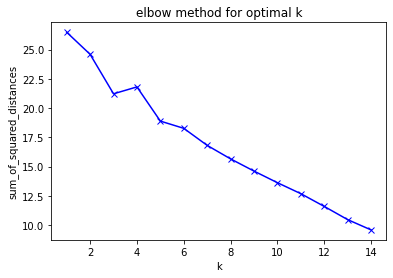

In [228]:
import matplotlib.pyplot as plt

#for each value of k, we can initialise k_means and use inertia to identify the sum of squared distances of samples to the nearest cluster centre
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(df)
    sum_of_squared_distances.append(k_means.inertia_)
    
    
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow method for optimal k')
plt.show()

In [229]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=3)
#Run the clustering algorithm
model = k_means.fit(df)
model
#Generate cluster predictions and store in y_hat
y_hat = k_means.predict(X)
y_hat

array([2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 0, 0, 0, 0])

In [230]:
labels=list(y_hat)
df_sum2['Label']=labels
df_sum2.to_csv('df_sum_clustering.csv')
df_sum2.head(2)

,AwardID,Abstract,Abstract_Tokens,Abstract2,Label
0,0110599,The investigators will conduct a series of exp...,"[investigator, conduct, series, experiment, fo...",investigator conduct series experiment focus c...,2
1,0112426,This program produces a cadre of computer scie...,"[program, produce, cadre, computer, scientist,...",program produce cadre computer scientist stron...,2


In [232]:
df_sum2[df_sum2['Label']==0]

,AwardID,Abstract,Abstract_Tokens,Abstract2,Label
25,0225421,The science erk () project seeks to bring l...,"[science, erk, project, seek, bring, informati...",science erk project seek bring information man...,0
26,0225473,The science erk () project seeks to bring l...,"[science, erk, project, seek, bring, informati...",science erk project seek bring information man...,0
27,0225495,Meers The science erk () project seeks to br...,"[meers, science, erk, project, seek, bring, in...",meers science erk project seek bring informati...,0
28,0225508,The science erk () project seeks to bring l...,"[science, erk, project, seek, bring, informati...",science erk project seek bring information man...,0
29,0225543,Arrowsmith The science erk () project seeks ...,"[arrowsmith, science, erk, project, seek, brin...",arrowsmith science erk project seek bring info...,0


In [60]:
#make array from number of occurrences
occ = np.asarray(X.sum(axis=0)).ravel().tolist()

In [62]:
bowListFrame = pd.DataFrame({'term': v.get_feature_names(), 'occurrences': occ})
bowListFrame

,term,occurrences
0,ability,0.290547
1,ablamowicz,0.030533
2,able,0.055422
3,abstract,0.074508
4,academic,0.204240
...,...,...
1644,yamacrew,0.103869
1645,year,0.197243
1646,yet,0.055461
1647,york,0.091565


In [64]:
import texthero as hero
df_sum2['tfidf'] = hero.tfidf(df_sum2['Abstract2'])
df_sum2.head(2)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\WIN\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-64-9445b50fd6c6>", line 1, in <module>
    import texthero as hero
  File "C:\Users\WIN\Anaconda3\lib\site-packages\texthero\__init__.py", line 12, in <module>
    from . import visualization
  File "C:\Users\WIN\Anaconda3\lib\site-packages\texthero\visualization.py", line 9, in <module>
    from nltk import NLTKWordTokenizer
ImportError: cannot import name 'NLTKWordTokenizer' from 'nltk' (C:\Users\WIN\Anaconda3\lib\site-packages\nltk\__init__.py)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\WIN\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'ImportError' object has no attribute '_render_traceback_'


ImportError: cannot import name 'NLTKWordTokenizer' from 'nltk' (C:\Users\WIN\Anaconda3\lib\site-packages\nltk\__init__.py)

__TEST__

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfs = tfidf.fit_transform(df_sum2['Abstract'].values)
tfs.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
from sklearn.neighbors import NearestNeighbors

model_tf_idf = NearestNeighbors(metric='cosine', algorithm='brute')
model_tf_idf.fit(tfs)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [35]:
model_tf_idf.transforms(tfs)

AttributeError: 'NearestNeighbors' object has no attribute 'transforms'